### Connect to EvaDB

In [ ]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
def pretty_print(df):
    return display(HTML(df.to_html().replace("\n","")))

In [ ]:
# Getting the video files
!wget -nc "https://www.dropbox.com/scl/fi/xo5bje08xtl7km0x4s2g2/videoplayback.mp4?rlkey=rd06wurlu70dgb0kkyacxoglv&dl=0" -O videoplayback.mp4

File ‘videoplayback.mp4’ already there; not retrieving.


### Load the videos for analysis

We use a regular expression to load all the videos into the table in a single command

In [ ]:
cursor.query("DROP TABLE IF EXISTS ObjectDetectionVideos;").df()
cursor.query("LOAD VIDEO 'videoplayback.mp4' INTO ObjectDetectionVideos").df()

,0
0,Number of loaded VIDEO: 1


### Register YOLO Object Detector as an User-Defined Function (UDF) in EvaDB

In [ ]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS Yolo
    TYPE ultralytics
    MODEL 'yolov8m.pt';
""").df()

,0
0,"Function Yolo already exists, nothing added."


### Run the YOLO Object Detector on the video

In [ ]:
yolo_query = cursor.query("""
    SELECT id, Yolo(data)
    FROM ObjectDetectionVideos
    WHERE id < 20
""")
response = yolo_query.df()
response

,id,labels,bboxes,scores
0,0,[car],"[[277.20001220703125, 112.20752716064453, 357....",[0.92]
1,1,[car],"[[277.2157287597656, 112.22871398925781, 357.6...",[0.92]
2,2,[car],"[[277.213623046875, 112.231689453125, 357.6813...",[0.92]
3,3,[car],"[[277.2126159667969, 112.23457336425781, 357.6...",[0.92]
4,4,[car],"[[277.2140197753906, 112.23907470703125, 357.6...",[0.92]
5,5,[car],"[[277.2107238769531, 112.23768615722656, 357.6...",[0.92]
6,6,"[car, car]","[[277.2088623046875, 112.24456787109375, 357.6...","[0.92, 0.47]"
7,7,"[car, car]","[[277.2082214355469, 112.22642517089844, 357.6...","[0.92, 0.42]"
8,8,[car],"[[277.2078552246094, 112.22561645507812, 357.6...",[0.92]
9,9,"[car, car]","[[277.2055358886719, 112.22859191894531, 357.6...","[0.92, 0.58]"


### Visualizing output of the Object Detector on the video

In [ ]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()

    while ret:
        df = detections
        df = df[['bboxes', 'labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness)
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()


        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

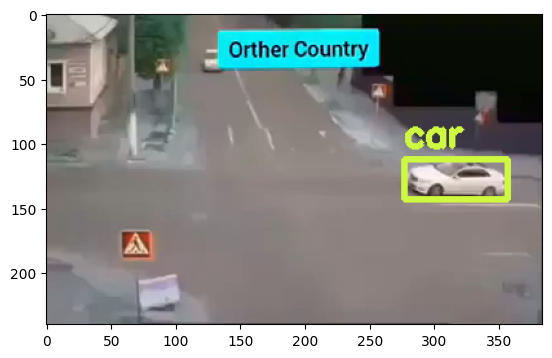

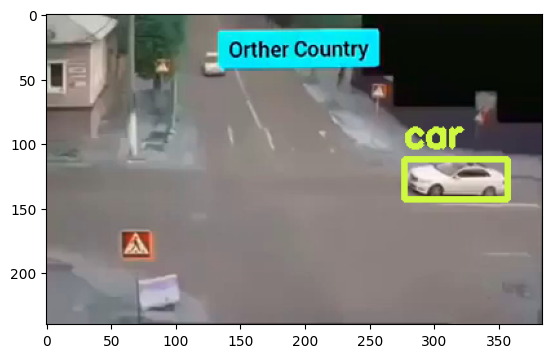

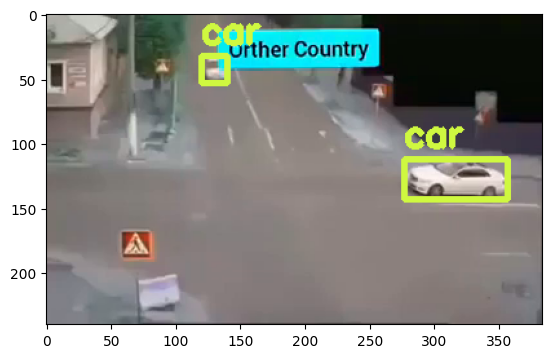

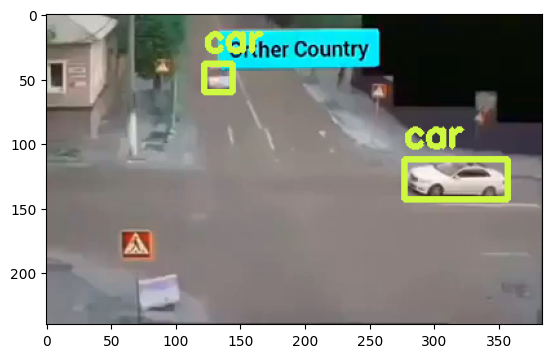

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x00\x7f\xd0...')

In [ ]:
from ipywidgets import Video, Image
input_path = 'videoplayback.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)
Video.from_file(output_path)